# Vision Transformer 

This notebook presents training toy ViT model on MNIST dataset. 

### Sources

1. [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)
2. [Vision Transformer (ViT): An Image is Worth 16x16 Words & Transformers for Computer Vision Overview](https://www.youtube.com/watch?v=TrdevFK_am4)
3. [Transformer from Scratch Python: A Step by Step Guide](https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c)

### Setup

In [1]:
import math
import os
from functools import cached_property
from typing import Any, Callable, Iterable, Tuple

import numpy as np
import seaborn as sns
import torch
import torchvision
import lovely_tensors as lt
import wandb
from skimage import io
from sklearn import metrics
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
lt.monkey_patch()

### Dataset

Create dataset using `torchvision` built in utils.

In [3]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # convert PIL to tensor
    torchvision.transforms.Lambda(lambda image: image.squeeze()),  # convert shape from (BATCH_SIZE, 1, X, Y) to (BATCH_SIZE, X * Y)
])

train_dataset = torchvision.datasets.MNIST("../data", download=True, transform=transforms, train=True)
test_dataset = torchvision.datasets.MNIST("../data", download=True, transform=transforms, train=False)

The choice of `batch_size` will impact training speed, for transformers the batch size should be relatively large in most cases.

In [4]:
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [5]:
for x, y in train_data_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([128, 28, 28])
torch.Size([128])


Sample one element from the dataset and visualize it using `skimage`.

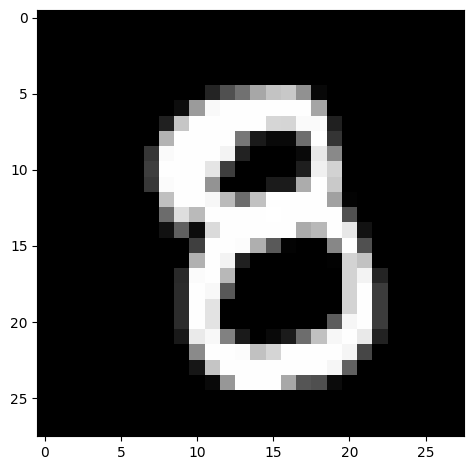

In [6]:
_ = io.imshow(x[0].numpy())

# Model

Model will follow down-sized VIT architecture, where patches are adjusted to small size of images in the dataset. Depth of the model and feedforward dimensions will also be reduced, to allow faster training.

### Patcher

VIT model can only process images in patches, utility class is implemented for this purpose. It splits each image into very small, 4x4 patches (original paper uses 16x16 patches). This will allow the model to use attention mechanism to process the image, since the patches will be treated as words and seuqence of patches as a sentence (intuition). 

The code is also available in `src/patcher.py`.

In [7]:
class ImagePatcher(torch.nn.Module):
    """
    Class is used to patch images into slices so it can be processed by transformer model.
    """

    def __init__(self, patch_size: int, stride: int, device: str = "cpu"):
        """
        :param patch_size: Size of the patch to be extracted from the image.
        :param stride: The stride with which the patch is extracted, for grayscale image it should be patch_size / 2
        :param device: Device on which the tensor should be stored,
                       Implementation works only for CPU, but class can cast output to GPU for easier usage.
        """
        super().__init__()

        self.patch_size = patch_size
        self.stride = stride
        self.device = device

    def patchify(self, image: torch.Tensor) -> torch.Tensor:
        patched = image.unfold(0, size=self.patch_size, step=self.stride).unfold(
            1, size=self.patch_size, step=self.stride
        )
        patched = patched.flatten(0, 1).flatten(-2, -1)
        return patched

    def forward(self, batch: torch.Tensor) -> torch.Tensor:
        """Converts a tensor of shape (BATCH_SIZE, X, Y) to (BATCH_SIZE, X * Y / PATCH_SIZE, PATCH_SIZE)"""
        return torch.stack([self.patchify(image.cpu()) for image in batch]).to(self.device)


Exampel patcher instance processing batch of MNIST images.

In [8]:
patcher = ImagePatcher(patch_size=4, stride=4, device="cpu")
patcher(x).shape

torch.Size([128, 49, 16])

Define positional encoding module

In [9]:
class PositionalEncoder(torch.nn.Module):
    """
    Positional encoder used to encode position of the patch in the image or element in sequence.
    Based on the implementation provided by PyTorch: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model: int = 16, max_len: int = 50, dropout: float = 0.0, device: str = "cpu"):
        """
        :param d_model: dimension of the transformer model
        :param max_len: maximum length of the sequence supported by encoding module
        :param dropout: probability of an element to be dropped out
        """
        super().__init__()

        self.d_model = d_model
        self.max_len = max_len
        self.device = device
        self.registered: bool = False

        self.dropout = torch.nn.Dropout(p=dropout).to(device)

    @cached_property
    def positional_encoding(self) -> torch.Tensor:
        position = torch.arange(self.max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2) * (-math.log(10000.0) / self.d_model))
        encoding = torch.zeros(self.max_len, self.d_model)

        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)

        return encoding.to(self.device)

    @torch.no_grad()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.positional_encoding[:x.size(1), :]
        return self.dropout(x)


In [10]:
encoder = PositionalEncoder(d_model=1024, max_len=50)
output = encoder.forward(torch.zeros(8, 50, 1024))

output.shape

torch.Size([8, 50, 1024])

Plotting single example of positional encoding.

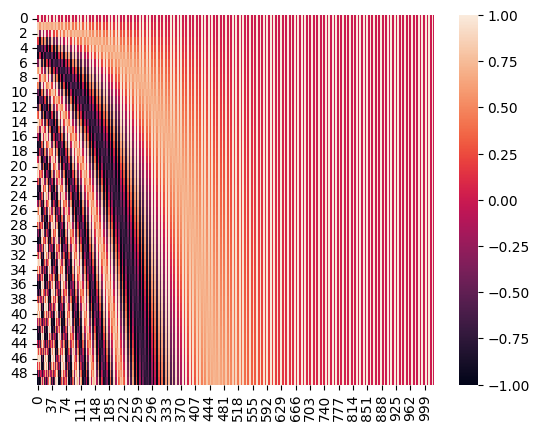

In [11]:
_ = sns.heatmap(output[0, :, :].numpy())

In [12]:
encoder = PositionalEncoder(d_model=16, max_len=16)
output = encoder.forward(torch.zeros(16, 16))

output.shape

torch.Size([16, 16])

### Encoder

Create VIT model for MNIST dataset. The model works in following steps:
1. Split image into patches
2. Embed each patche
3. Add positional encoding to each patch
4. Pass patches through transformer encoder
5. Using learned linear layer concatenate into single embedding
6. Pass through classification head to get logits

In [13]:
class MiniVisionTransformerClassifier(torch.nn.Module):
    """
    Mini Vision Transformer classifier is a minimal auto-didactic implementation of the Vision Transformer model
    based on the paper: https://arxiv.org/abs/2010.11929
    """

    def __init__(
        self,
        model_dim: int,
        patch_size: int,
        patches_in_image: int,
        num_classes: int,
        num_heads: int,
        num_layers: int,
        dim_feedforward: int,
        device: str = "cuda",
    ):
        """
        :param model_dim: dimension of the transformer model
        :param patch_size: size of the patch to be extracted from the image
        :param patches_in_image: number of patches in the image
        :param num_classes: number of classes in the dataset
        :param num_heads: number of heads in the transformer model
        :param num_layers: number of layers in the encoder stack of the transformer model
        :param dim_feedforward: dimension of the feedforward network in the transformer model
        """
        super().__init__()

        self.patcher = ImagePatcher(patch_size=patch_size, stride=patch_size, device=device)
        self.embedding = torch.nn.Linear(in_features=model_dim, out_features=model_dim, bias=False).to(device)
        self.positional_encoding = PositionalEncoder(d_model=model_dim, max_len=1 + patches_in_image, device=device)
        self.pooler = torch.nn.Linear(in_features=patches_in_image * model_dim, out_features=model_dim).to(device)

        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(
                d_model=model_dim, nhead=num_heads, dim_feedforward=dim_feedforward, batch_first=True
            ),
            num_layers=num_layers,
        ).to(device)

        self.classifier = torch.nn.Linear(in_features=model_dim, out_features=num_classes).to(device)

    def forward(self, batch: torch.Tensor, return_embeddings: bool = False) -> torch.Tensor:
        patches = self.patcher(batch)
        embeddings = self.embedding(patches)
        embeddings = self.positional_encoding(embeddings)
        embeddings = self.encoder(embeddings)

        outputs = self.pooler(embeddings.flatten(start_dim=1))
        logits = self.classifier(outputs)
        predictions = torch.nn.functional.softmax(logits, dim=-1)

        return predictions


Create instance of the model and look at its structure.

In [14]:
transformer = MiniVisionTransformerClassifier(model_dim=16, patch_size=4, patches_in_image=49, num_classes=10, num_heads=2, num_layers=2, dim_feedforward=2048, device="cuda")

Passing single batch return tensor of shape `[batch_size, num_classes]`, in each row there is a probability distribution over classes, which sums up to 1.

In [15]:
with torch.no_grad():
    y = transformer(x.cuda())

y.shape, y[0].sum()

(torch.Size([128, 10]), tensor cuda:0 1.000)

# Training

Define a training loop for the VIT model using W&B along with some utils for logging to W&B.

Firstly, define a function prediction on given `data_loader`, it can be any Iterable working in batches. 

In [16]:
def predict(model: torch.nn.Module, data_loader: Iterable) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Prediction loop for the given model and data loader
    :note: assumes running on CUDA enabled device
    """
    model = model.eval()
    targets, predictions = [], []

    for inputs, y_true in data_loader:
        with torch.no_grad():
            inputs = inputs.cuda()
            y_true = y_true.cuda()

            y_pred = model(inputs)

            predictions.append(y_pred)
            targets.append(y_true)

    return torch.cat(targets), torch.cat(predictions)


def evaluate(y_true: Iterable, y_pred: Iterable) -> dict[str, float]:
    return {
        "accuracy": metrics.accuracy_score(y_true, y_pred),
        "precision": metrics.precision_score(y_true, y_pred, zero_division=0, average="macro"),
        "recall": metrics.recall_score(y_true, y_pred, zero_division=0, average="macro"),
        "f1_score": metrics.f1_score(y_true, y_pred, zero_division=0, average="macro"),
    }


### Utils

Add a number of training utils for adding accuracy and F1 score metrics to W&B and parameter counting function.

In [17]:
def log_training_progress(model: torch.nn.Module, epoch: int, data_loader: Iterable) -> None:
    """
    Logs progress of the model training to W&B
    :note: requires Wto be called inside W&B run
    """
    logs = {}
    targets, predictions = predict(model, data_loader)

    logs["accuracy"] = metrics.accuracy_score(targets.cpu(), predictions.cpu().argmax(dim=-1))
    logs["f1_score"] = metrics.f1_score(
        targets.cpu(), predictions.cpu().argmax(dim=-1), zero_division=0, average="macro"
    )

    wandb.log(logs, step=epoch)


def count_trainable_parameters(model: torch.nn.Module) -> int:
    """Return the number of trainable parameters in neural model"""
    return sum(param.numel() for param in model.parameters() if param.requires_grad)


In [18]:
targets, predictions = predict(transformer, test_data_loader)
targets.shape, predictions.shape

(torch.Size([10000]), torch.Size([10000, 10]))

Evaluate untrained model on test set. It should perform randomly, which means around 10% accuracy.

In [19]:
print(metrics.classification_report(targets.cpu(), predictions.cpu().argmax(dim=-1), zero_division=0))

              precision    recall  f1-score   support

           0       0.25      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.10      0.95      0.18       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.09     10000
   macro avg       0.04      0.10      0.02     10000
weighted avg       0.03      0.09      0.02     10000



In [20]:
def train_test_split_data_loader(dataset, test_size: float = 0.1):
    train_indices, validation_indices = train_test_split(range(len(dataset)), test_size=test_size, random_state=42)
    
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    validation_dataset = torch.utils.data.Subset(dataset, validation_indices)
    
    train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
    validation_data_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=128, shuffle=False)
    
    return train_data_loader, validation_data_loader

Add training loop, which consists of following steps:
1. Create training and validation data loaders.
2. Train model for `epochs` number of epochs.
3. Evaluate model on test set.
4. Save model and add it to W&B artifacts.

In [21]:
def train(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    loss_function: Callable,
    dataset: Iterable,
    n_epochs: int,
    validation_size: float = 0.1,
) -> torch.nn.Module:
    """
    Train loop for the given torch model
    :note: assumes running on CUDA enabled device
    """
    train_data_loader, validation_data_loader = train_test_split_data_loader(dataset, test_size=validation_size)

    for epoch in range(n_epochs):
        for x, y in train_data_loader:
            model = model.train()
            x = x.cuda()
            y = y.cuda()

            optimizer.zero_grad()
            y_pred = model(x)

            loss_value = loss_function(y_pred, y)
            loss_value.backward()
            optimizer.step()
       
        log_training_progress(model, epoch, validation_data_loader)

    return model


def run(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    loss_function: Callable,
    train_dataset: Iterable,
    test_dataset: Iterable,
    n_epochs: int,
    config: dict[str, Any],
    validation_size=0.1,
) -> None:
    """
    Run training and evaluation loop for the given model and data

    :param model: pytorch model to train
    :param optimizer: pytorch optimizer to use
    :param loss_function: pytorch loss function to use
    :param train_dataset: iterable dataset for training
    :param test_dataset: iterable dataset for testing
    :param n_epochs: number of epochs to train
    :param config: dictionary with configuration for W&B
    :param validation_size: size of the validation set
    """
    with wandb.init(project=config["project_name"], name=config["run_name"]):
        wandb.log(config)
        test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)
        # run training and evaluation
        model = train(model, optimizer, loss_function, train_dataset, n_epochs, validation_size)
        targets, predictions = predict(model, test_data_loader)
        # log metrics and model info to W&B
        wandb.log(evaluate(targets.cpu(), predictions.cpu().argmax(dim=-1)))
        wandb.log({"n_trainable_parameters": count_trainable_parameters(model)})
        # save model to file and upload to W&B
        path = os.path.join(wandb.run.dir, "model.pt")
        torch.save(model.state_dict(), path)
        torch.save(model.state_dict(), "model.pt")
        wandb.save(path)
    
    return model

In [22]:
optimizer = torch.optim.AdamW(transformer.parameters(), lr=1e-4)
loss_function = torch.nn.CrossEntropyLoss()

config = {
    "project_name": "vision-transformer",
    "run_name": "initial-run",
    "dataset": "MNIST",
    "model": "Mini-ViT",
    "optimizer": "AdamW",
    "loss_function": "CrossEntropyLoss",
}

In [23]:
trained_transformer = run(
    transformer,
    optimizer,
    loss_function,
    train_dataset,
    test_dataset,
    n_epochs=30,
    config=config
)

wandb: Currently logged in as: kzajac. Use `wandb login --relogin` to force relogin


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███████████
f1_score,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███████████
n_trainable_parameters,▁
precision,▁
recall,▁
accuracy,0.9674
dataset,MNIST
f1_score,0.96723
loss_function,CrossEntropyLoss
model,Mini-ViT
n_trainable_parameters,150490


In [25]:
trained_transformer = trained_transformer.eval()

targets, predictions = predict(trained_transformer, test_data_loader)
targets = targets.cpu().numpy()
predictions = predictions.cpu().argmax(dim=-1).numpy()

print(metrics.classification_report(y_pred=predictions, y_true=targets, zero_division=0))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.99      0.98      0.98      1135
           2       0.96      0.97      0.96      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.97      0.96      0.97       892
           6       0.97      0.97      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.93      0.97      0.95       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

